##Load Dataset and libraries

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import img_to_array



from keras import regularizers
import pandas as pd
import numpy as np
import keras
from tensorflow.keras.optimizers import RMSprop
import skimage
import matplotlib.pyplot as plt
import cv2
from skimage import color
from skimage.transform import resize, rotate
from skimage.util import crop
from re import X
import keras
from keras.regularizers import l2

In [4]:
SIZE = 256

#！！ use cropped data
# Data set
# For training /content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_sketches
image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_photos/'
img_array = []

sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_sketches/'
sketch_array = []

# For testing
test_image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos/'
test_img_array = []

test_sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_sketches/'
test_sketch_array = []


# Image and their corresponding file names in a sorted manner based on their names
image_file = sorted(os.listdir(image_path))
sketch_file = sorted(os.listdir(sketch_path))
test_image_file = sorted(os.listdir(test_image_path))
test_sketch_file = sorted(os.listdir(test_sketch_path))
# to get the files in proper order


##Define preprocessing of image and sketch

In [5]:
def image_preprocessing1(file_name, img_path, size):
  storage_array = []
  for img_file in tqdm(file_name):
    x = img_path + img_file
    img = (resize(plt.imread(x).astype('float32'),(SIZE,SIZE), anti_aliasing=True))/255.0
    storage_array.append(img)

    # horizontal flip 
    img1 = cv2.flip(img,1)
    storage_array.append(img_to_array(img1))
  
    #vertical flip 
    img2 = cv2.flip(img,-1)
    storage_array.append(img_to_array(img2))

    # rotate clockwise 
    img3 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    storage_array.append(img_to_array(img3))

     # rotate anti clockwise 
    img4 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    storage_array.append(img_to_array(img4))
    '''
    # flip rotated image 
    img7 = cv2.flip(img4,1)
    storage_array.append(img_to_array(img7))
   ''' 
  # Returning storage array where we have stored all our pre-processed images
  return np.array(storage_array)

# For sketch images
def image_preprocessing2(file_name, img_path, size):
  storage_array = []
  for img_file in tqdm(file_name):
    x = img_path + img_file
    a = cv2.imread(x).astype('float32')
    # Removing irrelevant text from image
    a = a[55:]
    # Resizing
    a=resize(a,(SIZE, SIZE), anti_aliasing=True)
    # Normalization of array
    a = (a - 127.5) / 127.5
    img = a
    storage_array.append(img)

    # horizontal flip 
    img1 = cv2.flip(img,1)
    storage_array.append(img_to_array(img1))

    #vertical flip 
    img2 = cv2.flip(img,-1)
    storage_array.append(img_to_array(img2))

    # rotate clockwise 
    img3 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    storage_array.append(img_to_array(img3))

     # rotate anti clockwise 
    img4 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    storage_array.append(img_to_array(img4))
  '''
    # flip rotated image 
    img7 = cv2.flip(img4,1)
    storage_array.append(img_to_array(img7))
   ''' 
  # Returning storage array where we have stored all our pre-processed images
  return np.array(storage_array) 

Do preprocessing

In [6]:
img_array = image_preprocessing1(image_file, image_path, SIZE)
sketch_array = image_preprocessing2(sketch_file, sketch_path, SIZE)
test_img_array = image_preprocessing1(test_image_file, test_image_path, SIZE)
test_sketch_array = image_preprocessing2(test_sketch_file, test_sketch_path, SIZE)

100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


In [7]:

# Print the number of colored and sketch images present
print("Total number of Training images:",len(img_array))
print("Total number of Training sketch:",len(sketch_array))

print("Total number of Testing images:",len(test_img_array))
print("Total number of Testing sketch :",len(test_sketch_array))

Total number of Training images: 440
Total number of Training sketch: 440
Total number of Testing images: 500
Total number of Testing sketch : 500


In [8]:

y_test = test_img_array
x_test = test_sketch_array
y_train = img_array
x_train = sketch_array
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((440, 256, 256, 3),
 (440, 256, 256, 3),
 (500, 256, 256, 3),
 (500, 256, 256, 3))

## Define Conv AE Model

In [9]:

input_img = keras.Input(shape=(256, 256, 3))

x = keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2)(input_img)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(32, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (4, 4), activation='relu',strides=2)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(128, (4, 4), activation='relu',strides=2)(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(256, (4, 4), activation='relu',strides=2)(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(512, (4, 4),activation='swish',strides=2)(x)
x=keras.layers.BatchNormalization()(x)
encoded=keras.layers.LeakyReLU()(x)

# Decoder start
x = keras.layers.Conv2DTranspose(512, (4, 4), activation='relu',strides=2)(encoded)
x=keras.layers.Dropout(0.1)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(256, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(128, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.Dropout(0.1)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(64, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(32, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(16, (4, 4),activation='relu',strides=2)(x)
x=keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(8, (2, 2),activation='relu',padding='valid',strides=(1,1))(x)
decoded = keras.layers.Conv2DTranspose(3, (2, 2),activation='relu',padding='valid',strides=(1,1))(x)


model_convAE = keras.Model(input_img, decoded)
# Separable conv encoder
model_convAE_encoder = keras.Model(input_img, encoded)

##Training and testing

###MSE

Epoch 1/100
14/14 [==============================] - 21s 453ms/step - loss: 0.3147 - accuracy: 0.1789 - val_loss: 0.3773 - val_accuracy: 0.0633
Epoch 2/100
14/14 [==============================] - 3s 216ms/step - loss: 0.1887 - accuracy: 0.1528 - val_loss: 0.3075 - val_accuracy: 0.0468
Epoch 3/100
14/14 [==============================] - 3s 221ms/step - loss: 0.1621 - accuracy: 0.1387 - val_loss: 0.1982 - val_accuracy: 0.0961
Epoch 4/100
14/14 [==============================] - 3s 220ms/step - loss: 0.1506 - accuracy: 0.1729 - val_loss: 0.1914 - val_accuracy: 0.1589
Epoch 5/100
14/14 [==============================] - 3s 221ms/step - loss: 0.1317 - accuracy: 0.2127 - val_loss: 0.1821 - val_accuracy: 0.1445
Epoch 6/100
14/14 [==============================] - 3s 219ms/step - loss: 0.1081 - accuracy: 0.1949 - val_loss: 0.1733 - val_accuracy: 0.1270
Epoch 7/100
14/14 [==============================] - 3s 222ms/step - loss: 0.0651 - accuracy: 0.2736 - val_loss: 0.1431 - val_accuracy: 0.275

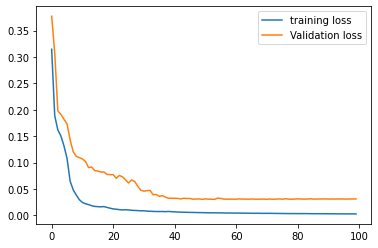

In [10]:
model_convAE.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

model_convAE.fit(x_train, y_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, y_test))

plt.plot(model_convAE.history.history["loss"])
plt.plot(model_convAE.history.history["val_loss"])
plt.legend(['training loss', 'Validation loss'])

斜体文本

16/16 [==============================] - 1s 59ms/step


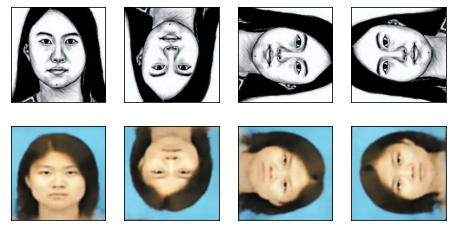

In [11]:

decoded_imgs = model_convAE.predict(x_test)
clip=np.clip(decoded_imgs,0,1)
n = 10
fig=plt.figure(figsize=(20, 4))
for i in range(1,5):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(clip[i].astype('float32'))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

16/16 [==============================] - 1s 54ms/step


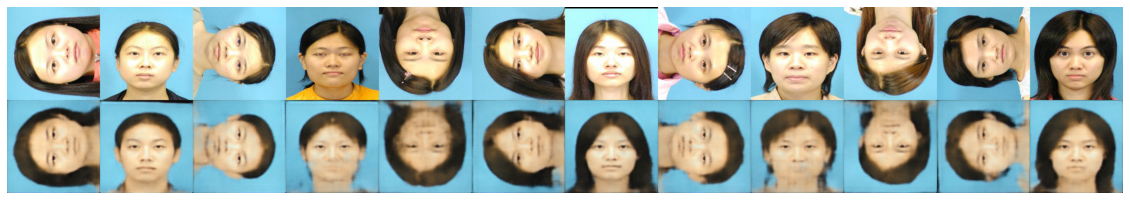

In [12]:
decoded_imgs = model_convAE.predict(x_test)
some_photos = []
sketch_photos = []
for i in range(9, 90, 7):
  some_photos.append(y_test[i])
  sketch_photos.append(decoded_imgs[i])


X = np.concatenate(some_photos, axis=1)
Y = np.concatenate(sketch_photos, axis=1)

plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([X,Y]))
plt.axis("OFF")
plt.show()

### MAE

Epoch 1/100
14/14 [==============================] - 10s 349ms/step - loss: 0.1321 - accuracy: 0.8499 - val_loss: 0.1508 - val_accuracy: 0.7156
Epoch 2/100
14/14 [==============================] - 3s 230ms/step - loss: 0.0728 - accuracy: 0.8752 - val_loss: 0.1286 - val_accuracy: 0.8715
Epoch 3/100
14/14 [==============================] - 3s 232ms/step - loss: 0.0584 - accuracy: 0.9026 - val_loss: 0.1199 - val_accuracy: 0.8836
Epoch 4/100
14/14 [==============================] - 3s 234ms/step - loss: 0.0504 - accuracy: 0.9108 - val_loss: 0.1210 - val_accuracy: 0.8809
Epoch 5/100
14/14 [==============================] - 3s 236ms/step - loss: 0.0452 - accuracy: 0.9124 - val_loss: 0.1199 - val_accuracy: 0.8781
Epoch 6/100
14/14 [==============================] - 3s 237ms/step - loss: 0.0427 - accuracy: 0.9116 - val_loss: 0.1208 - val_accuracy: 0.8793
Epoch 7/100
14/14 [==============================] - 3s 237ms/step - loss: 0.0410 - accuracy: 0.9129 - val_loss: 0.1193 - val_accuracy: 0.879

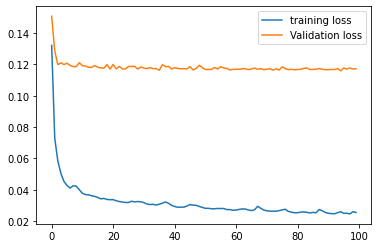

In [13]:

model_convAE.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

model_convAE.fit(x_train, y_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, y_test))

plt.plot(model_convAE.history.history["loss"])
plt.plot(model_convAE.history.history["val_loss"])
plt.legend(['training loss', 'Validation loss'])

16/16 [==============================] - 1s 59ms/step


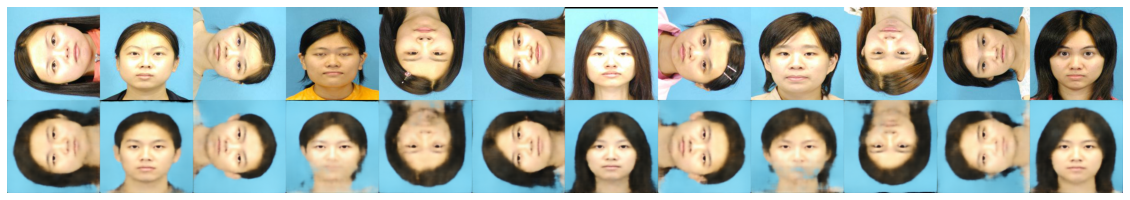

In [14]:
decoded_imgs = model_convAE.predict(x_test)
some_photos = []
sketch_photos = []
for i in range(9, 90, 7):
  some_photos.append(y_test[i])
  sketch_photos.append(decoded_imgs[i])


X = np.concatenate(some_photos, axis=1)
Y = np.concatenate(sketch_photos, axis=1)

plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([X,Y]))
plt.axis("OFF")
plt.show()

###BCE

Epoch 1/100
14/14 [==============================] - 10s 357ms/step - loss: 0.4928 - accuracy: 0.9132 - val_loss: 0.5844 - val_accuracy: 0.8722
Epoch 2/100
14/14 [==============================] - 3s 237ms/step - loss: 0.4888 - accuracy: 0.9243 - val_loss: 0.5817 - val_accuracy: 0.8717
Epoch 3/100
14/14 [==============================] - 3s 238ms/step - loss: 0.4874 - accuracy: 0.9246 - val_loss: 0.5738 - val_accuracy: 0.8533
Epoch 4/100
14/14 [==============================] - 3s 240ms/step - loss: 0.4869 - accuracy: 0.9276 - val_loss: 0.5731 - val_accuracy: 0.8789
Epoch 5/100
14/14 [==============================] - 3s 242ms/step - loss: 0.4866 - accuracy: 0.9277 - val_loss: 0.5887 - val_accuracy: 0.8045
Epoch 6/100
14/14 [==============================] - 3s 243ms/step - loss: 0.4871 - accuracy: 0.9242 - val_loss: 0.5773 - val_accuracy: 0.8658
Epoch 7/100
14/14 [==============================] - 3s 244ms/step - loss: 0.4867 - accuracy: 0.9271 - val_loss: 0.5776 - val_accuracy: 0.879

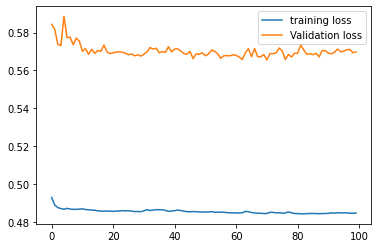

In [15]:

model_convAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_convAE.fit(x_train, y_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, y_test))

plt.plot(model_convAE.history.history["loss"])
plt.plot(model_convAE.history.history["val_loss"])
plt.legend(['training loss', 'Validation loss'])
     

16/16 [==============================] - 1s 59ms/step


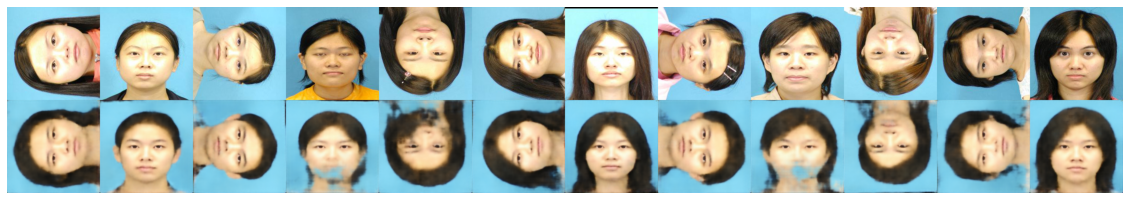

In [16]:
decoded_imgs = model_convAE.predict(x_test)
some_photos = []
sketch_photos = []
for i in range(9, 90, 7):
  some_photos.append(y_test[i])
  sketch_photos.append(decoded_imgs[i])


X = np.concatenate(some_photos, axis=1)
Y = np.concatenate(sketch_photos, axis=1)

plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([X,Y]))
plt.axis("OFF")
plt.show()